# Автозаполнение объявления по изображению (v1.0)

Ноутбук содержит эксперименты с мультимодальной моделью CLIP
для работы с изображениями и текстовыми описаниями объявлений.

Данный ноутбук является следующим этапом проекта
после парсинга объявлений.

## Постановка задачи

Цель проекта — автоматически сформировать черновик объявления о товаре
по одному или нескольким изображениям.

По изображению требуется предсказать структурированные атрибуты
(категория, пол, состояние, тип лота), а также сгенерировать
черновое текстовое описание объявления.

Проект ориентирован на практическое применение
(маркетплейсы, классифайды, боты, сервисы автозаполнения).

In [11]:
# Установка дополнительных зависимостей (если не установлены)
!pip install git+https://github.com/openai/CLIP.git

  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-81bg_5q3
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-81bg_5q3
  Resolved https://github.com/openai/CLIP.git to commit dcba3cb2e2827b402d2701e7e1c7d9fed8a20ef1
  Preparing metadata (setup.py) ... done


## Установка зависимостей

In [3]:
import numpy as np
import json
import re
from pathlib import Path
from collections import Counter
import clip
from PIL import Image
from tqdm import tqdm
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics.pairwise import cosine_similarity
from rouge_score import rouge_scorer
from collections import defaultdict

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader

import random
import matplotlib.pyplot as plt
import pickle

## Данные
В работе используется локально собранный датасет объявлений
с изображениями товаров одежды.

Каждый объект включает:
- изображения товара;
- структурированные атрибуты (category, gender, condition, lot_type);
- текстовое описание (description).

Изображения используются как основной вход модели.
HTML-страницы и изображения не публикуются из-за объёма и ограничений по правам,
используются только производные JSONL-файлы.

In [4]:
DATA_DIR = Path("data/datasets")
OUT_ALL = DATA_DIR / "dataset_all.jsonl"
OUT_ENRICHED = DATA_DIR / "dataset_enriched.jsonl"
OUT_FINAL = DATA_DIR / "dataset_final.jsonl"
IMG_EXTS = {".jpg", ".jpeg", ".png", ".webp"}

### Структура хранения изображений

Изображения объявлений были загружены ранее (см. код в `parser.ipynb`) и сохранены в иерархической структуре:

<pre>
data/images/
├── dress/
│   └── 2038884474/
│       ├── 0.jpg
│       ├── 1.jpg
│       └── ...
├── top/
└── ...
</pre>

Каждая категория содержит подкаталоги с идентификаторами объявлений, внутри которых хранятся изображения.

In [48]:
IMAGES_DIR = Path("data/images")
RAW_PATTERN = "dataset_*.jsonl"

print("Папка с изображениями существует:", IMAGES_DIR.exists())
print("Примеры категорий в images/:")
for p in IMAGES_DIR.iterdir():
    if p.is_dir():
        print("-", p.name)

Папка с изображениями существует: True
Примеры категорий в images/:
- dress_woman
- outerwear_man
- outerwear_woman
- skirt_woman
- top_man
- top_woman
- trousers_man
- trousers_woman


In [55]:
jsonl_files = sorted(DATA_DIR.glob(RAW_PATTERN))

print("Найдено jsonl файлов:", len(jsonl_files))
for p in jsonl_files:
    print("-", p.name)

Найдено jsonl файлов: 8
- dataset_dress_woman.jsonl
- dataset_outerwear_man.jsonl
- dataset_outerwear_woman.jsonl
- dataset_skirt_woman.jsonl
- dataset_top_man.jsonl
- dataset_top_woman.jsonl
- dataset_trousers_man.jsonl
- dataset_trousers_woman.jsonl


### Объединение метаданных объявлений с изображениями

В данном блоке выполняется сопоставление текстовых метаданных объявлений с соответствующими изображениями и формирование базовой версии датасета.

#### Извлечение метаданных из имени файла

Функция `parse_meta_from_filename` используется для извлечения категории товара и пола (`gender`) из имени исходного `jsonl`-файла.  
Имена файлов имеют стандартизованный формат `dataset_<category>_<gender>.jsonl`, что позволяет восстанавливать данные признаки без обращения к содержимому файла.

---

#### Сопоставление объявлений и изображений

Для каждого `jsonl`-файла последовательно обрабатываются все объявления:
- определяется категория и пол из имени файла;
- формируется имя директории изображений в формате `<category>_<gender>`;
- для каждого объявления проверяется наличие соответствующей директории изображений по идентификатору объявления;
- из директории выбираются файлы с допустимыми расширениями изображений.

Объявления без директории изображений или без файлов изображений исключаются из датасета и учитываются в счётчиках пропусков.

---

#### Формирование структуры датасета

Для каждого валидного объявления формируется запись со следующими полями:
- `id` — идентификатор объявления;
- `image_paths` — пути к изображениям объявления;
- `category`, `gender` — категориальные признаки;
- `title_gt`, `description_gt` — эталонные текстовые поля;
- `characteristics` — структурированные характеристики товара;
- `category_level_3` — уточнённая категория товара.

Сформированные записи сохраняются в файл `dataset_all.jsonl`.

---

#### Статистика и контроль качества

В процессе обработки собирается:
- общее количество сохранённых объектов;
- число объявлений без папки изображений;
- число объявлений без изображений внутри папки;
- распределение объявлений по парам `(категория, пол)`.

Данные показатели используются для контроля качества сформированного датасета и выявления проблем на этапе парсинга и загрузки изображений.

In [56]:
def parse_meta_from_filename(name):
    base = name.replace("dataset_", "").replace(".jsonl", "")
    parts = base.split("_")
    return parts[0], parts[-1]  # category, gender


rows = []
stats = Counter()
missing_img_dirs = 0
missing_images = 0

for path in jsonl_files:
    category, gender = parse_meta_from_filename(path.name)

    img_category = f"{category}_{gender}"  # <-- КЛЮЧЕВОЕ ИЗМЕНЕНИЕ

    with path.open(encoding="utf-8") as f:
        for line in f:
            row = json.loads(line)

            img_dir = IMAGES_DIR / img_category / str(row["ad_id"])
            if not img_dir.exists():
                missing_img_dirs += 1
                continue

            images = [
                p for p in img_dir.iterdir()
                if p.is_file() and p.suffix.lower() in IMG_EXTS
            ]

            if not images:
                missing_images += 1
                continue

            rows.append({
                "id": row["ad_id"],
                "image_paths": sorted(str(p) for p in images),
                "category": category,
                "gender": gender,
                "title_gt": row["title"],
                "description_gt": row["description_clean"],
                "characteristics": row.get("characteristics", {}),
                "category_level_3": row.get("category_level_3"),
            })

            stats[(category, gender)] += 1


with OUT_ALL.open("w", encoding="utf-8") as f:
    for r in rows:
        f.write(json.dumps(r, ensure_ascii=False) + "\n")

print("Всего объектов:", len(rows))
print("Нет папки с изображениями:", missing_img_dirs)
print("Папка есть, но нет картинок:", missing_images)

print("\nРаспределение по категориям:")
for k, v in stats.items():
    print(k, ":", v)

Всего объектов: 1799
Нет папки с изображениями: 11
Папка есть, но нет картинок: 0

Распределение по категориям:
('dress', 'woman') : 177
('outerwear', 'man') : 178
('outerwear', 'woman') : 172
('skirt', 'woman') : 229
('top', 'man') : 230
('top', 'woman') : 379
('trousers', 'man') : 234
('trousers', 'woman') : 200


### Нормализация и извлечение дополнительных признаков

В данном блоке реализованы функции для нормализации текстовых характеристик объявлений и извлечения дополнительных категориальных признаков, используемых при дальнейшем анализе и формировании финального датасета.

---

#### Нормализация состояния товара

Функция `normalize_condition` приводит текстовое описание состояния товара к ограниченному набору стандартных классов:
- `new` — новое изделие или наличие бирок;
- `like_new` — состояние «как новое»;
- `good` — хорошее состояние;
- `worn` — удовлетворительное состояние или б/у;
- `unknown` — состояние не определено.

Нормализация снижает вариативность пользовательских описаний и упрощает дальнейшую агрегацию и анализ данных.

---

#### Извлечение подтипа товара

Функция `extract_subtype` используется для определения подтипа товара на основе нескольких источников информации с убывающим приоритетом:
1. структурированные характеристики (`characteristics`), содержащие ключи, связанные с типом или предметом;
2. поле `category_level_3`, если оно задано и не равно значению «другое»;
3. заголовок объявления (`title_gt`) как резервный источник.

Для категории `dress` дополнительно учитываются наиболее частотные подтипы (вечернее и повседневное платье).  
При невозможности извлечения подтипа возвращается значение `unknown`.

---

#### Определение типа лота

Функция `extract_lot_type` классифицирует объявления по типу лота:
- `single` — один предмет;
- `multi_mixed` — набор или комплект разных товаров;
- `multi_same` — партия однотипных товаров.

Классификация основана на поиске ключевых слов в заголовке и описании объявления.


In [57]:
def normalize_condition(val):
    v = val.lower()
    if "бирк" in v or v == "новое":
        return "new"
    if "отлич" in v or "как нов" in v:
        return "like_new"
    if "хорош" in v:
        return "good"
    if "удовлетвор" in v or "б/у" in v:
        return "worn"
    return "unknown"


def extract_subtype(row):
    ch = row.get("characteristics", {})
    category = row.get("category")

    # 1. characteristics
    for k, v in ch.items():
        if isinstance(k, str) and isinstance(v, str):
            if "тип" in k.lower() or "предмет" in k.lower():
                v_l = v.lower()
                if category == "dress":
                    if "вечер" in v_l:
                        return "вечернее платье"
                    if "повсед" in v_l:
                        return "повседневное платье"
                return v_l

    # 2. category_level_3
    lvl3 = row.get("category_level_3")
    if isinstance(lvl3, str) and lvl3.strip().lower() != "другое":
        return lvl3.strip().lower()

    # 3. title
    title = row.get("title_gt", "").lower()
    m = re.match(r"[а-яёa-z][а-яёa-z\- ]{2,40}", title)
    return m.group(0).strip() if m else "unknown"


def extract_lot_type(title, desc):
    text = f"{title} {desc}".lower()
    if any(w in text for w in ["комплект", "ассортимент", "набор"]):
        return "multi_mixed"
    if any(w in text for w in ["оптом", "разные размеры", "партия"]):
        return "multi_same"
    return "single"

### Обогащение датасета нормализованными признаками

В данном блоке выполняется добавление нормализованных и извлечённых признаков к базовой версии датасета.

---

#### Обработка записей датасета

Для каждой записи из файла `dataset_all.jsonl`:
- нормализуется состояние товара (`condition_gt`) на основе поля «Состояние»;
- извлекается подтип товара (`subtype_gt`) с использованием структурированных и текстовых источников;
- определяется тип лота (`lot_type_gt`) по заголовку и описанию объявления.

Полученные признаки добавляются непосредственно в структуру записи.

---

#### Формирование обогащённого датасета

Все обработанные записи сохраняются в файл `dataset_enriched.jsonl`.  
Данный датасет используется как вход для последующих этапов фильтрации и формирования финальной выборки.

---

#### Статистика и контроль распределений

В процессе обогащения собирается статистика по комбинациям признаков `(condition_gt, lot_type_gt)`.  
Вывод наиболее частотных комбинаций позволяет:
- оценить распределение состояний и типов лотов;
- выявить возможные перекосы или аномалии в данных;
- проверить корректность работы функций нормализации и извлечения признаков.

In [58]:
rows_out = []
stats = Counter()

with OUT_ALL.open(encoding="utf-8") as f:
    for line in f:
        row = json.loads(line)

        row["condition_gt"] = normalize_condition(
            row["characteristics"].get("Состояние", "")
        )
        row["subtype_gt"] = extract_subtype(row)
        row["lot_type_gt"] = extract_lot_type(
            row["title_gt"], row["description_gt"]
        )

        rows_out.append(row)
        stats[(row["condition_gt"], row["lot_type_gt"])] += 1


with OUT_ENRICHED.open("w", encoding="utf-8") as f:
    for r in rows_out:
        f.write(json.dumps(r, ensure_ascii=False) + "\n")

print("Сохранено объектов:", len(rows_out))
for k, v in stats.most_common(10):
    print(k, v)

Сохранено объектов: 1799
('new', 'single') 1053
('like_new', 'single') 471
('new', 'multi_mixed') 128
('good', 'single') 68
('new', 'multi_same') 54
('like_new', 'multi_mixed') 15
('worn', 'single') 7
('good', 'multi_same') 1
('like_new', 'multi_same') 1
('worn', 'multi_same') 1


### Формирование финальной структуры датасета

В данном блоке выполняется приведение обогащённого датасета к финальной структуре, используемой в задаче автозаполнения черновика объявления.

---

#### Преобразование записей

Для каждой записи из файла `dataset_enriched.jsonl` формируется упрощённая и стандартизованная структура:
- сохраняются идентификатор объявления и пути к изображениям;
- все целевые текстовые и категориальные признаки объединяются в поле `draft_gt`.

Поле `draft_gt` содержит эталонный черновик объявления, включающий:
- заголовок;
- категорию и пол;
- подтип товара;
- состояние товара;
- тип лота;
- текстовое описание.

---

#### Сохранение финального датасета

Сформированные записи сохраняются в файл `dataset_final.jsonl`.  
Полученный датасет используется как целевая разметка (`ground truth`) для обучения и оценки мультимодальных моделей генерации черновиков объявлений.

---

#### Контроль результата

Выводится общее количество объектов в финальном датасете и путь к сохранённому файлу, что позволяет убедиться в корректном завершении этапа формирования данных.


In [59]:
final_rows = []

with OUT_ENRICHED.open(encoding="utf-8") as f:
    for line in f:
        row = json.loads(line)

        final_rows.append({
            "id": row["id"],
            "image_paths": row["image_paths"],
            "draft_gt": {
                "title": row["title_gt"],
                "category": row["category"],
                "gender": row["gender"],
                "subtype": row["subtype_gt"],
                "condition": row["condition_gt"],
                "lot_type": row["lot_type_gt"],
                "description": row["description_gt"],
            }
        })

with OUT_FINAL.open("w", encoding="utf-8") as f:
    for r in final_rows:
        f.write(json.dumps(r, ensure_ascii=False) + "\n")

print("Финальный датасет:", len(final_rows))
print("Файл:", OUT_FINAL)

Финальный датасет: 1799
Файл: data\datasets\dataset_final.jsonl


## ML-часть: автозаполнение черновика объявления по изображению

В данном разделе реализуется базовый мультимодальный пайплайн для автозаполнения структурированного черновика объявления на основе изображения товара.

### Загрузка и подготовка данных в среде Kaggle

Для обучения и экспериментов используется среда Kaggle.  
Финальный датасет и изображения подключаются как внешние read-only ресурсы. Возможно выполнение ноутбука на одном устройстве или переход в данной части на более производительные ресурсы

Определяются пути:
- `dataset_final.jsonl` — финальный датасет с эталонными черновиками объявлений;
- директория изображений, организованная по схеме `<category>_<gender>/<ad_id>/`.

In [5]:
# Kaggle paths

KAGGLE_DATASET_PATH = Path("/kaggle/input/avito-html/datasets/datasets/dataset_final.jsonl")
KAGGLE_IMAGES_ROOT = Path("/kaggle/input/avito-html/images/images")

### Загрузка CLIP и настройка устройства

Используется предобученная мультимодальная модель CLIP (`ViT-B/32`), применяемая как фиксированный экстрактор визуальных признаков.

Модель переводится в режим `eval`, обучение весов CLIP не выполняется.  
Вычисления автоматически выполняются на GPU при его наличии.

In [6]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Device:", device)

model, preprocess = clip.load("ViT-B/32", device=device)
model.eval()

print("CLIP model loaded")

Device: cpu


100%|███████████████████████████████████████| 338M/338M [00:22<00:00, 15.4MiB/s]


CLIP model loaded


### Загрузка финального датасета

Финальный датасет загружается из файла `dataset_final.jsonl`.  
Каждая запись содержит:
- пути к изображениям объявления;
- эталонный черновик (`draft_gt`) с категорией, полом, состоянием, типом лота и описанием.

Данный датасет используется как основа для обучения и оценки моделей.


In [7]:
rows = []
with KAGGLE_DATASET_PATH.open(encoding="utf-8") as f:
    for line in f:
        rows.append(json.loads(line))

print("Загружено объектов:", len(rows))

Загружено объектов: 1799


### Извлечение визуальных эмбеддингов изображений

Для каждого объявления:
- выбирается первое изображение;
- изображение преобразуется с помощью стандартного препроцессинга CLIP;
- извлекается 512-мерный эмбеддинг изображения;
- эмбеддинг нормализуется по L2-норме.

Полученные эмбеддинги используются как входные признаки для последующих моделей.

In [8]:
image_embeddings = []
targets = []
bad_images = 0

for r in tqdm(rows):
    category = r["draft_gt"]["category"]
    gender = r["draft_gt"]["gender"]
    ad_id = str(r["id"])

    img_dir = KAGGLE_IMAGES_ROOT / f"{category}_{gender}" / ad_id

    if not img_dir.exists():
        bad_images += 1
        continue

    images = sorted(img_dir.glob("*"))
    if not images:
        bad_images += 1
        continue

    img = Image.open(images[0]).convert("RGB")
    img_input = preprocess(img).unsqueeze(0).to(device)

    with torch.no_grad():
        emb = model.encode_image(img_input)
        emb = emb / emb.norm(dim=-1, keepdim=True)

    image_embeddings.append(emb.cpu())
    targets.append({
        "category": category,
        "gender": gender,
        "condition": r["draft_gt"]["condition"],
        "lot_type": r["draft_gt"]["lot_type"],
    })

image_embeddings = torch.cat(image_embeddings, dim=0)

print("Embeddings shape:", image_embeddings.shape)
print("Пропущено изображений:", bad_images)

100%|██████████| 1799/1799 [04:57<00:00,  6.05it/s]

Embeddings shape: torch.Size([1799, 512])
Пропущено изображений: 0


### Подготовка целевых меток

Категориальные признаки:
- `category`,
- `gender`,
- `condition`,
- `lot_type`

кодируются с помощью `LabelEncoder`.  
Для каждого признака сохраняется соответствие между числовыми метками и исходными значениями.

In [9]:
label_encoders = {}
y = {}

fields = ["category", "gender", "condition", "lot_type"]

for field in fields:
    le = LabelEncoder()
    y[field] = le.fit_transform([t[field] for t in targets])
    label_encoders[field] = le
    print(field, "classes:", list(le.classes_))

category classes: [np.str_('dress'), np.str_('outerwear'), np.str_('skirt'), np.str_('top'), np.str_('trousers')]
gender classes: [np.str_('man'), np.str_('woman')]
condition classes: [np.str_('good'), np.str_('like_new'), np.str_('new'), np.str_('worn')]
lot_type classes: [np.str_('multi_mixed'), np.str_('multi_same'), np.str_('single')]


### Разделение данных на обучающую и валидационную выборки

Данные случайным образом разбиваются на обучающую и валидационную выборки
в пропорции 80/20.

Разбиение выполняется по индексам эмбеддингов и согласовано для всех целевых признаков.

In [28]:
X = image_embeddings.float().numpy()

idx = np.arange(len(X))
train_idx, val_idx = train_test_split(
    idx, test_size=0.2, random_state=42, shuffle=True
)

print("Train:", len(train_idx), "Val:", len(val_idx))

y_train = {k: np.array(v)[train_idx] for k, v in y.items()}
y_val   = {k: np.array(v)[val_idx]   for k, v in y.items()}

X_train = X[train_idx]
X_val   = X[val_idx]

Train: 1439 Val: 360


## Dataset и DataLoader

Определяется пользовательский класс `EmbDataset`, возвращающий:
- эмбеддинг изображения;
- набор целевых меток для всех предсказываемых признаков.

Создаются `DataLoader` для обучающей и валидационной выборок с батч-обработкой.

In [30]:
class EmbDataset(Dataset):
    def __init__(self, X, y_dict):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = {k: torch.tensor(v, dtype=torch.long) for k, v in y_dict.items()}
        self.fields = list(y_dict.keys())

    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, i):
        item = {"x": self.X[i]}
        for f in self.fields:
            item[f] = self.y[f][i]
        return item

train_ds = EmbDataset(X_train, y_train)
val_ds   = EmbDataset(X_val, y_val)

train_loader = DataLoader(train_ds, batch_size=128, shuffle=True, num_workers=2)
val_loader   = DataLoader(val_ds, batch_size=256, shuffle=False, num_workers=2)

n_classes = {
    "category": len(label_encoders["category"].classes_),
    "gender": len(label_encoders["gender"].classes_),
    "condition": len(label_encoders["condition"].classes_),
    "lot_type": len(label_encoders["lot_type"].classes_),
}
print("n_classes:", n_classes)

n_classes: {'category': 5, 'gender': 2, 'condition': 4, 'lot_type': 3}


### Многоголовочная классификационная модель

Используется нейросетевая модель с общей скрытой частью и отдельными выходными головами
для каждого предсказываемого признака:
- категория;
- пол;
- состояние;
- тип лота.

Такой подход позволяет совместно обучать связанные задачи (multi-task learning),
используя общее визуальное представление.

In [31]:
class MultiHeadClassifier(nn.Module):
    def __init__(self, in_dim=512, hidden=256, n_classes=None):
        super().__init__()
        assert n_classes is not None
        self.backbone = nn.Sequential(
            nn.Linear(in_dim, hidden),
            nn.ReLU(),
            nn.Dropout(0.2),
        )
        self.heads = nn.ModuleDict({
            k: nn.Linear(hidden, v) for k, v in n_classes.items()
        })

    def forward(self, x):
        h = self.backbone(x)
        return {k: head(h) for k, head in self.heads.items()}

model_cls = MultiHeadClassifier(in_dim=512, hidden=256, n_classes=n_classes).to(device)
print(model_cls)

MultiHeadClassifier(
  (backbone): Sequential(
    (0): Linear(in_features=512, out_features=256, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
  )
  (heads): ModuleDict(
    (category): Linear(in_features=256, out_features=5, bias=True)
    (gender): Linear(in_features=256, out_features=2, bias=True)
    (condition): Linear(in_features=256, out_features=4, bias=True)
    (lot_type): Linear(in_features=256, out_features=3, bias=True)
  )
)


### Обучение модели и оценка качества

Модель обучается с использованием функции потерь `CrossEntropyLoss`
для каждой выходной головы.

Качество оценивается на валидационной выборке по метрикам:
- accuracy;
- macro-F1.

Метрики считаются отдельно для каждого предсказываемого признака.

In [33]:
def eval_epoch(model, loader):
    model.eval()
    all_true = {k: [] for k in n_classes.keys()}
    all_pred = {k: [] for k in n_classes.keys()}

    with torch.no_grad():
        for batch in loader:
            x = batch["x"].to(device)
            logits = model(x)
            for k in n_classes.keys():
                y_true = batch[k].cpu().numpy()
                y_hat = torch.argmax(logits[k], dim=1).cpu().numpy()
                all_true[k].append(y_true)
                all_pred[k].append(y_hat)

    metrics = {}
    for k in n_classes.keys():
        yt = np.concatenate(all_true[k])
        yp = np.concatenate(all_pred[k])
        metrics[k] = {
            "acc": accuracy_score(yt, yp),
            "macro_f1": f1_score(yt, yp, average="macro"),
        }
    return metrics

In [34]:
optimizer = torch.optim.AdamW(model_cls.parameters(), lr=2e-3, weight_decay=1e-4)
criterion = nn.CrossEntropyLoss()

EPOCHS = 8

for epoch in range(1, EPOCHS + 1):
    model_cls.train()
    running = 0.0
    n_batches = 0

    for batch in train_loader:
        x = batch["x"].to(device)

        optimizer.zero_grad()
        logits = model_cls(x)

        loss = 0.0
        for k in n_classes.keys():
            yb = batch[k].to(device)
            loss = loss + criterion(logits[k], yb)

        loss.backward()
        optimizer.step()

        running += loss.item()
        n_batches += 1

    train_loss = running / max(1, n_batches)
    val_metrics = eval_epoch(model_cls, val_loader)

    print(f"Epoch {epoch}/{EPOCHS} | train_loss={train_loss:.4f}")
    for k, m in val_metrics.items():
        print(f"  {k:10s} acc={m['acc']:.3f} macro_f1={m['macro_f1']:.3f}")

Epoch 1/8 | train_loss=4.2891
  category   acc=0.322 macro_f1=0.097
  gender     acc=0.653 macro_f1=0.395
  condition  acc=0.686 macro_f1=0.203
  lot_type   acc=0.897 macro_f1=0.315
Epoch 2/8 | train_loss=3.3840
  category   acc=0.400 macro_f1=0.196
  gender     acc=0.686 macro_f1=0.517
  condition  acc=0.686 macro_f1=0.203
  lot_type   acc=0.897 macro_f1=0.315
Epoch 3/8 | train_loss=3.1624
  category   acc=0.472 macro_f1=0.272
  gender     acc=0.750 macro_f1=0.685
  condition  acc=0.686 macro_f1=0.203
  lot_type   acc=0.897 macro_f1=0.315
Epoch 4/8 | train_loss=2.8630
  category   acc=0.597 macro_f1=0.441
  gender     acc=0.786 macro_f1=0.759
  condition  acc=0.686 macro_f1=0.203
  lot_type   acc=0.897 macro_f1=0.315
Epoch 5/8 | train_loss=2.6543
  category   acc=0.678 macro_f1=0.580
  gender     acc=0.803 macro_f1=0.788
  condition  acc=0.689 macro_f1=0.223
  lot_type   acc=0.897 macro_f1=0.315
Epoch 6/8 | train_loss=2.4274
  category   acc=0.708 macro_f1=0.636
  gender     acc=0.792

### Векторное представление датасета и поиск ближайших соседей

Все эмбеддинги изображений нормализуются и объединяются в матрицу признаков.

На их основе реализуется поиск ближайших соседей по косинусному сходству,
который используется как простейший retrieval-baseline для генерации описаний.

In [35]:
E = image_embeddings.numpy()
E = E / np.linalg.norm(E, axis=1, keepdims=True)

print("Embedding matrix shape:", E.shape)

Embedding matrix shape: (1799, 512)


### Генерация описаний на основе retrieval-baseline

Описание объявления формируется на основе:
- категории и пола товара;
- состояния товара;
- текстов описаний ближайших визуально похожих объявлений.

Исп объясняется как baseline-подход, не использующий генеративные языковые модели,
а опирающийся исключительно на реальные данные датасета.

Для повышения качества retrieval вводится ограничение:
поиск ближайших соседей выполняется только среди объявлений
с совпадающими значениями `(category, gender)`.

Это позволяет снизить семантические ошибки и повысить согласованность генерируемых текстов.

In [39]:
# индексируем объекты по (category, gender)
index_by_class = defaultdict(list)

for i, r in enumerate(rows):
    key = (
        r["draft_gt"]["category"],
        r["draft_gt"]["gender"],
    )
    index_by_class[key].append(i)

print("Пример ключей:", list(index_by_class.keys())[:5])

Пример ключей: [('dress', 'woman'), ('outerwear', 'man'), ('outerwear', 'woman'), ('skirt', 'woman'), ('top', 'man')]


In [40]:
def retrieve_neighbors_class_aware(query_idx, k=5):
    meta = rows[query_idx]["draft_gt"]
    key = (meta["category"], meta["gender"])

    candidates = index_by_class[key]
    if len(candidates) <= 1:
        return []

    cand_embeddings = E[candidates]

    sims = cosine_similarity(
        E[query_idx:query_idx+1],
        cand_embeddings
    )[0]

    # исключаем сам объект
    self_pos = candidates.index(query_idx) if query_idx in candidates else None
    if self_pos is not None:
        sims[self_pos] = -1

    top = np.argsort(sims)[-k:][::-1]
    return [candidates[i] for i in top]

In [47]:
RU_CATEGORY = {
    "dress": "Платье",
    "top": "Топ",
    "trousers": "Брюки",
    "skirt": "Юбка",
    "outerwear": "Верхняя одежда",
}

RU_GENDER = {
    "woman": "для женщин",
    "man": "для мужчин",
}

RU_CONDITION = {
    "new": "новое",
    "like_new": "как новое",
    "good": "в хорошем состоянии",
    "worn": "б/у",
}

def build_description_class_aware(idx, k=5):
    nn_idx = retrieve_neighbors_class_aware(idx, k=k)

    texts = [
        rows[i]["draft_gt"]["description"]
        for i in nn_idx
        if rows[i]["draft_gt"]["description"]
    ]

    base = texts[0].split(".")[0] if texts else ""

    meta = rows[idx]["draft_gt"]

    descr = (
        f"{RU_CATEGORY[meta['category']]} {RU_GENDER[meta['gender']]}.\n"
        f"Состояние: {RU_CONDITION[meta['condition']]}.\n"
        f"{base}"
    )
    return descr

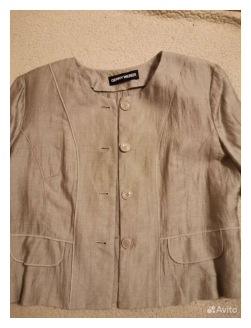

GT description:
 платье жакет продаю комплектом длина платья 93см хб и гипюр есть подклад на всю длину платья цвет такой если в серый бы добавить капельку зелёного отдам в подарок поясок покупалось в цуме дорого одевала не более 5 раз в отличном состоянии если мне будет по пути могу подвезти сама

Generated description:
 Платье для женщин.
Состояние: как новое.
продаётся вечернее платье бренда lapland из полиэстера и шерсти размер 50 l xl коричневое платье с оригинальным воротником и декоративными элементами на рукавах длина изделия 103см длина рукава 40см ширина плеч 40 см обхват груди 60 см платье в отличном состоянии подходит для особых случаев


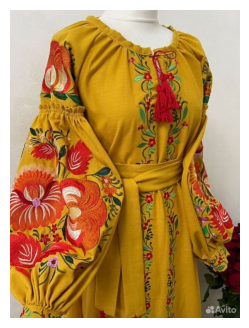

GT description:
 вышиванка платье женское эксклюзив медовая леди ценность 32000 руб вышивка в технике гладь орнамент старинный лен который позволяет вам комфортно себя чувствовать на протяжении дня не мнется сильно есть два вида пошива и предлагаю два вида ткани на данную модель 32 38 и 48 тысяч потрясающая версия п

Generated description:
 Платье для женщин.
Состояние: новое.
продам платье италия очень красивое мягкое будет красиво с туфлями или сапогами


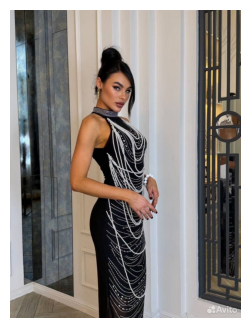

GT description:
 nеw уеаr соllестiоn живые фото и видео топовое платье красотка размер м 44 л 46 хл 48 2хл 50 ткань трикотаж сетка любимая моделька в отличном качестве шикарная обработка из шикарной бижутерии придает особого шика вы будете королевой вечера отличная посадка не просвечивает длина изделия по спинке 130

Generated description:
 Платье для женщин.
Состояние: новое.
nеw уеаr соllестiоn батальная серия живые фото и видео превосходное платье коrоlеvа размер 44 46 48 50 52 54 ткань королевский велюр отличный вариант для торжества потрясные расцветки придаёт особого шика женственно и в то же время сексуально вы будете в центре внимания на любом мероприятии длина изделия 140 см полномерные рост модели 170 см


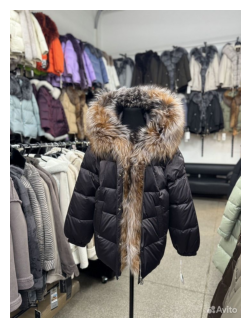

GT description:
 пуховик с натуральным мехом писца наш магазин sinаli занимается продажей верхней одежды уже более 15 лет мы гарантируем вам качество и высокий сервис мы уверены что правильно подобранная одежда это залог уверенности и успеха адрес нашего магазина г новосибирск ул большевистская 45 1 режим работы 9 0

Generated description:
 Верхняя одежда для женщин.
Состояние: новое.
пальто шкрсть кашемир c норкой в наличии фабрика роdiuм качество люкс размер легкий оверсайз от 42 до 54 56 p р не потеряйте объявление сохраните в избранном длина изделия по спинке 75 см цвета черный пудра беж коричневый в наличии в москве доставка и примерка самовывоз авито доставка условия уточняем


In [67]:
def show_image_for_idx(idx):
    meta = rows[idx]["draft_gt"]
    ad_id = str(rows[idx]["id"])
    img_dir = KAGGLE_IMAGES_ROOT / f"{meta['category']}_{meta['gender']}" / ad_id
    images = sorted(img_dir.glob("*"))
    if not images:
        return None
    return Image.open(images[0]).convert("RGB")

for i in [0, 10, 100, 500]:
    print("=" * 80)

    img = show_image_for_idx(i)
    if img is not None:
        plt.figure(figsize=(4, 4))
        plt.imshow(img)
        plt.axis("off")
        plt.show()

    print("GT description:\n", rows[i]["draft_gt"]["description"][:300])
    print("\nGenerated description:\n", build_description_class_aware(i))

### Улучшения:
* Категория соблюдается (платья ≠ пальто, верхняя одежда ≠ платье).
* Тексты:
  * более реалистичные,
  * «авитошные»,
  * без визуальных галлюцинаций.
* Генерация использует реальные данные датасета, а не выдумку.

### Проблемные места:
* Бренды и размеры иногда «чужие».
* Текст может быть слишком общим.
* Нет строгой привязки к конкретным деталям GT.

### Формирование итогового черновика объявления

Финальный черновик объявления включает:
- автоматически сформированный заголовок;
- категорию, пол, состояние и тип лота;
- сгенерированное описание.

Полученная структура соответствует целевому формату задачи
автозаполнения объявления по изображению.

In [49]:
def build_title(idx):
    meta = rows[idx]["draft_gt"]

    cat = meta["category"]
    gender = "женское" if meta["gender"] == "woman" else "мужское"

    subtype = meta.get("subtype", "")
    condition = meta["condition"].replace("_", " ")

    if subtype and subtype != "unknown":
        base = subtype
    else:
        base = cat

    title = f"{base} {gender}, {condition}"
    return title

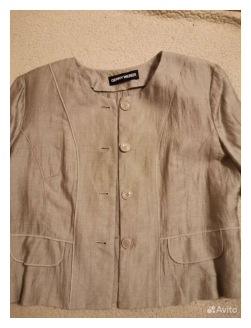

{'title': 'повседневное платье женское, like new', 'category': 'dress', 'gender': 'woman', 'condition': 'like_new', 'lot_type': 'multi_mixed', 'description': 'Платье для женщин.\nСостояние: как новое.\nпродаётся вечернее платье бренда lapland из полиэстера и шерсти размер 50 l xl коричневое платье с оригинальным воротником и декоративными элементами на рукавах длина изделия 103см длина рукава 40см ширина плеч 40 см обхват груди 60 см платье в отличном состоянии подходит для особых случаев'}


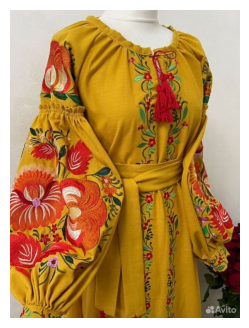

{'title': 'повседневное платье женское, new', 'category': 'dress', 'gender': 'woman', 'condition': 'new', 'lot_type': 'single', 'description': 'Платье для женщин.\nСостояние: новое.\nпродам платье италия очень красивое мягкое будет красиво с туфлями или сапогами'}


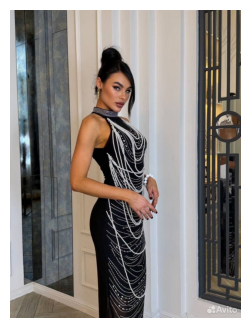

{'title': 'вечернее платье женское, new', 'category': 'dress', 'gender': 'woman', 'condition': 'new', 'lot_type': 'single', 'description': 'Платье для женщин.\nСостояние: новое.\nnеw уеаr соllестiоn батальная серия живые фото и видео превосходное платье коrоlеvа размер 44 46 48 50 52 54 ткань королевский велюр отличный вариант для торжества потрясные расцветки придаёт особого шика женственно и в то же время сексуально вы будете в центре внимания на любом мероприятии длина изделия 140 см полномерные рост модели 170 см'}


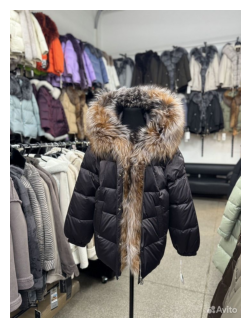

{'title': 'зимние куртки и пуховики женское, new', 'category': 'outerwear', 'gender': 'woman', 'condition': 'new', 'lot_type': 'multi_mixed', 'description': 'Верхняя одежда для женщин.\nСостояние: новое.\nпальто шкрсть кашемир c норкой в наличии фабрика роdiuм качество люкс размер легкий оверсайз от 42 до 54 56 p р не потеряйте объявление сохраните в избранном длина изделия по спинке 75 см цвета черный пудра беж коричневый в наличии в москве доставка и примерка самовывоз авито доставка условия уточняем'}


In [68]:
def build_draft(idx):
    return {
        "title": build_title(idx),
        "category": rows[idx]["draft_gt"]["category"],
        "gender": rows[idx]["draft_gt"]["gender"],
        "condition": rows[idx]["draft_gt"]["condition"],
        "lot_type": rows[idx]["draft_gt"]["lot_type"],
        "description": build_description_class_aware(idx),
    }

# проверка
for i in [0, 10, 100, 500]:
    print("=" * 40)
    
    img = show_image_for_idx(i)
    if img is not None:
        plt.figure(figsize=(4, 4))
        plt.imshow(img)
        plt.axis("off")
        plt.show()
        
    print(build_draft(i))

## Оценка качества
Качество классификации оценивается по accuracy и macro-F1.

Для оценки текстового описания используются:
- CLIPScore как мультимодальная метрика согласованности изображения и текста;
- ROUGE-L как вспомогательная текстовая метрика;
- sanity checks по длине и заполненности описаний.

In [63]:
def clip_score_image_text(img_emb, text, model, device, max_words=40):
    """
    img_emb: torch.Tensor shape (512,)
    text: str
    """
    # аккуратно режем текст
    words = text.split()
    if len(words) > max_words:
        text = " ".join(words[:max_words])

    with torch.no_grad():
        text_tokens = clip.tokenize([text], truncate=True).to(device)
        text_emb = model.encode_text(text_tokens)
        text_emb = text_emb / text_emb.norm(dim=-1, keepdim=True)

    score = torch.cosine_similarity(
        img_emb.unsqueeze(0).to(device),
        text_emb
    ).item()
    return score

In [64]:
N_EVAL = 300
eval_idx = random.sample(range(len(rows)), N_EVAL)

clip_scores = []

for idx in tqdm(eval_idx):
    img_emb = image_embeddings[idx]
    gen_text = build_description_class_aware(idx)

    score = clip_score_image_text(
        img_emb=img_emb,
        text=gen_text,
        model=model,
        device=device
    )
    clip_scores.append(score)

print("CLIPScore:")
print("  mean:", np.mean(clip_scores))
print("  std :", np.std(clip_scores))

100%|██████████| 300/300 [00:25<00:00, 11.89it/s]

CLIPScore:
  mean: 0.20430937404433885
  std : 0.026028064725855553


In [60]:
scorer = rouge_scorer.RougeScorer(["rougeL"], use_stemmer=True)

rouge_scores = []

for idx in eval_idx:
    gt = rows[idx]["draft_gt"]["description"]
    pred = build_description_class_aware(idx)

    if not gt or not pred:
        continue

    score = scorer.score(gt, pred)["rougeL"].fmeasure
    rouge_scores.append(score)

print("ROUGE-L:")
print("  mean:", np.mean(rouge_scores))
print("  std :", np.std(rouge_scores))

ROUGE-L:
  mean: 0.11200721046555963
  std : 0.21991361861269318


In [62]:
lengths = []
empty = 0

for idx in eval_idx:
    txt = build_description_class_aware(idx)
    if not txt.strip():
        empty += 1
    lengths.append(len(txt))

print("Description length:")
print("  mean:", np.mean(lengths))
print("  min :", np.min(lengths))
print("  max :", np.max(lengths))
print("Empty descriptions:", empty)

Description length:
  mean: 454.24666666666667
  min : 57
  max : 2371
Empty descriptions: 0


В рамках проекта реализован полный мультимодальный пайплайн
автозаполнения объявления по изображению.

Ограничения текущей версии:
- генерация описания основана на retrieval, а не на обучении
полноценной языковой модели;
- качество condition и lot_type ограничено дисбалансом классов;
- возможен перенос деталей (размеры, бренды) от похожих объявлений.

## Дополнительные примеры

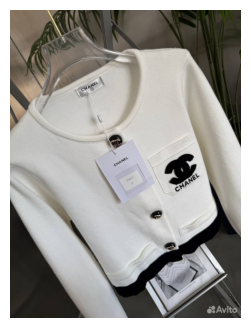

TITLE:
кардиган женское, new

DESCRIPTION:
Топ для женщин.
Состояние: новое.
женский лонгслив из хлопка размер one size новая вещь с биркой доставка в пункт авито яндекс 5пост

META:
{'category': 'top', 'gender': 'woman', 'condition': 'new', 'lot_type': 'single'}


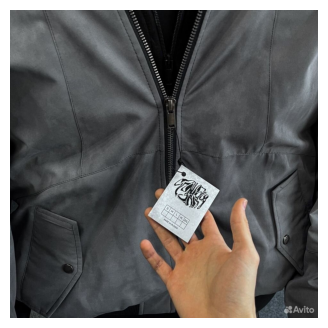

TITLE:
зимние куртки и пуховики мужское, new

DESCRIPTION:
Верхняя одежда для мужчин.
Состояние: новое.
пуховик с мехом alaska puffer type y2k стильный фасон утеплённый мех идеально подойдёт для зимы в наличии на руках пиши свой рост и вес в лс размерный ряд m l xl самовывоз г москва

META:
{'category': 'outerwear', 'gender': 'man', 'condition': 'new', 'lot_type': 'single'}


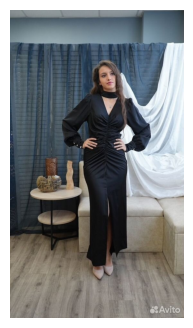

TITLE:
вечернее платье женское, like new

DESCRIPTION:
Платье для женщин.
Состояние: как новое.
вечернее платье на запах в отличном состоянии изготовлено из бархата что придает ему блеск и элегантность черный цвет делает его подходящим для особых случаев размер one size длина платья 88 см длина по спинке 84 см длина рукава от горлового шва 71см

META:
{'category': 'dress', 'gender': 'woman', 'condition': 'like_new', 'lot_type': 'single'}


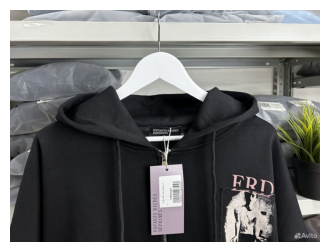

TITLE:
толстовка мужское, new

DESCRIPTION:
Топ для мужчин.
Состояние: новое.
худи оверсайз оптом состав 88 хлопок 12 эластан узбекистан размеры s xl отгружаем поразмерно без начеса плотность 380 гр цвет черный и серый меланж зип худи состав 88 хлопок 12 эластан плотность 380 гр ткань футер 3 х нитка петля без начеса отгружаем в день заказа работаем с физ и юр лицами цена указана за худи оверсайз тираж 50 шт напишите нам посчитаем стоимость за ваш тираж в профиле найдете футболки оптом футболки оверсайз оптом футболки варенки худи варенки худи оверсайз кепки шапки

META:
{'category': 'top', 'gender': 'man', 'condition': 'new', 'lot_type': 'single'}


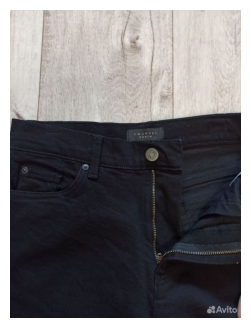

TITLE:
джинсы женское, new

DESCRIPTION:
Брюки для женщин.
Состояние: новое.
доставка яндекс почта и 5post каждый день авито пункт 3 раза в неделю джинсы утеплённые 44 размер новые сток без бирки замеры от 75 тянется на 5 6см об 90 но тоже тянется внутренний шов 80

META:
{'category': 'trousers', 'gender': 'woman', 'condition': 'new', 'lot_type': 'single'}


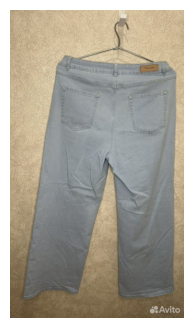

TITLE:
джинсы женское, like new

DESCRIPTION:
Брюки для женщин.
Состояние: как новое.
продаю женские джинсы zara размер 42 44 прямые длина от верха до низа 82

META:
{'category': 'trousers', 'gender': 'woman', 'condition': 'like_new', 'lot_type': 'single'}


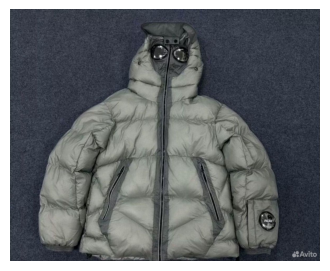

TITLE:
зимние куртки и пуховики мужское, new

DESCRIPTION:
Верхняя одежда для мужчин.
Состояние: новое.
абсолютно новый оригинал размеры в наличии m l xl подробности дополнительные фото и все остальные модели отправляем в личные сообщения

META:
{'category': 'outerwear', 'gender': 'man', 'condition': 'new', 'lot_type': 'multi_mixed'}


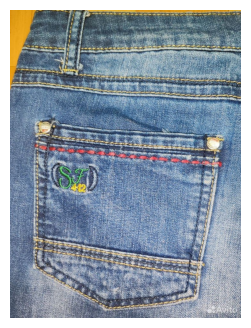

TITLE:
джинсы мужское, good

DESCRIPTION:
Брюки для мужчин.
Состояние: в хорошем состоянии.
оригинальные мужские джинсы cupo baxx ростовка 34 размер 34 российский 50 состояние идеальное талия 45 см бедра 57 см длина по наружному шву 95 см ширина штанины внизу 19 см ширина штанины в бедре 28 см прежде чем заказать одежду тщательно измерьте свои параметры

META:
{'category': 'trousers', 'gender': 'man', 'condition': 'good', 'lot_type': 'single'}


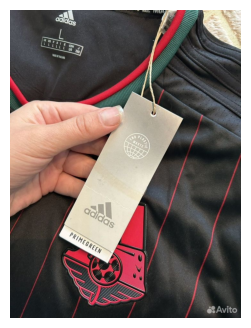

TITLE:
футболка женское, new

DESCRIPTION:
Топ для женщин.
Состояние: новое.
кардиган из шерсти stone island ghost размер m xl состояние абсолютно новый цена 31990 рублей доставка в любой город личная встреча москва любые проверки также доступен заказ с poizon

META:
{'category': 'top', 'gender': 'woman', 'condition': 'new', 'lot_type': 'single'}


In [71]:
SHOWCASE_N = 9
showcase_idx = random.sample(range(len(rows)), SHOWCASE_N)

for idx in showcase_idx:
    print("=" * 100)

    img = show_image_for_idx(idx)
    if img is not None:
        plt.figure(figsize=(4, 4))
        plt.imshow(img)
        plt.axis("off")
        plt.show()

    draft = build_draft(idx)

    print("TITLE:")
    print(draft["title"])
    print("\nDESCRIPTION:")
    print(draft["description"])
    print("\nMETA:")
    print({
        "category": draft["category"],
        "gender": draft["gender"],
        "condition": draft["condition"],
        "lot_type": draft["lot_type"],
    })

## Сохранение

Модель классификации и все необходимые данные (веса, кодировщики меток, метаданные) сохранены отдельно, что позволяет использовать обученную модель в дальнейшем в виде сервиса или бота без повторного обучения.

In [72]:
MODEL_DIR = Path("saved_model")
MODEL_DIR.mkdir(exist_ok=True)

model_path = MODEL_DIR / "classifier.pt"

torch.save({
    "model_state_dict": model_cls.state_dict(),
    "n_classes": n_classes,
    "embedding_dim": 512,
}, model_path)

print("Модель сохранена:", model_path.resolve())

Модель сохранена: /kaggle/working/saved_model/classifier.pt


In [73]:
encoders_path = MODEL_DIR / "label_encoders.pkl"

with open(encoders_path, "wb") as f:
    pickle.dump(label_encoders, f)

print("Label encoders сохранены:", encoders_path.resolve())

Label encoders сохранены: /kaggle/working/saved_model/label_encoders.pkl
